In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import ncdl
import os
import ncdl.nn as ncnn
from PIL import Image
from typing import Optional, Callable
from ncdl.nn.functional.downsample import downsample
from ncdl.nn.functional.upsample import upsample
from ncdl import pad_like
from utility import visualize_lattice
from torchsummary import summary


class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

image_transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((284, 284)),
    transforms.ToTensor()
])

train_image_dir = '/path/to/the/data'
train_mask_dir = '/path/to/the/data'
test_image_dir = '/path/to/the/data'
test_mask_dir = '/path/to/the/data'

batch_size = 8

train_dataset = CustomDataset(train_image_dir, train_mask_dir, image_transform=image_transform, mask_transform=mask_transform)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(test_image_dir, test_mask_dir, image_transform=image_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LatticeNormalizationWrapper class is from the following:
'''Horacsek, J. (2023). *Non-Cartesian Deep Learning (NCDL)* [Source code]. GitHub. 
   https://github.com/jjh13/NCDL/tree/master/ncdl'''
class LatticeNormalizationWrapper(nn.Module):
    def __init__(self, lattice, channels, normalization):
        super(LatticeNormalizationWrapper, self).__init__()
        assert normalization in [None, 'bn', 'gn', 'in']
        if normalization is None:
            self.module = nn.Identity()
        elif normalization == 'bn':
            self.module = ncnn.LatticeBatchNorm(lattice, channels)
        elif normalization == 'in':
            self.module = ncnn.LatticeInstanceNorm(lattice, channels)
        elif normalization == 'gn':
            group_size = [group_size for group_size in [8,4,2,1] if channels % group_size == 0][0]
            self.module = ncnn.LatticeGroupNorm(lattice, channels//group_size, channels)

    def forward(self, x):
        return self.module(x)
    
def increase_spatial_dimensions(image, pad_value=0):
    padded_image = nn.functional.pad(image, (1, 1, 1, 1), mode='constant', value=pad_value)
    return padded_image

    
class NCDL(nn.Module):
    def __init__(self, lattice: ncdl.Lattice, num_classes=10):
        super().__init__()
        
        self.lattice = lattice

        if lattice == ncdl.Lattice("qc"):
            stencil = ncdl.Stencil([
                (1, 1), (2, 2), (3, 1), (1, 3), (3, 3), (0, 2), (2, 0), (2, 4), (4, 2)

            ], lattice, center=(2, 2))
            
        # encoder
        self.layer2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer3 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=64, channels_out=160, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 160, 'bn'),
            ncnn.LeakyReLU())
        self.layer4 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(160, 400, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(400),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer5 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=400, channels_out=1024, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 1024, 'bn'),
            ncnn.LeakyReLU())

        # bottleneck
        self.layer7 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=1024, channels_out=1024, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 1024, 'bn'),
            ncnn.LeakyReLU())
        self.layer9 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=1024, channels_out=1024, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 1024, 'bn'),
            ncnn.LeakyReLU())
        
        # decoder
        self.layer17 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(1024, 400, kernel_size=4, stride=3, padding=0, output_padding=1))
        self.layer17sub = nn.Sequential(
            nn.Conv2d(800, 400, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(400),
            nn.LeakyReLU())
        self.layer18 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=400, channels_out=160, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 160, 'bn'),
            ncnn.LeakyReLU())
        self.layer19 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(160, 64, kernel_size=4, stride=3, padding=0, output_padding=2))
        self.layer19sub = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        self.layer20 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=64, channels_out=1, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 1, 'bn'),
            ncnn.LeakyReLU())
        
        self.layer28 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU())
        

    def forward(self, x):
        layer = ncnn.LatticeWrap()
        out2 = self.layer2(x)
#         print(out.shape)
        out = layer(out2)
        restore1 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = self.layer3(restore1)
        out1 = self.layer4(out)
#         print(out.shape)
        out = layer(out1)
        restore2 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = self.layer5(restore2)
    
        out = self.layer7(out)
        out = self.layer9(out)

        out = self.layer17(out)
#         print(out.shape)
        out = nn.functional.interpolate(out, size=(71, 71), mode='bilinear', align_corners=False)
        out = torch.cat([out, out1], dim=1)
        out = self.layer17sub(out)
#         print(out.shape)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore2)
        out = self.layer18(out)
        out = self.layer19(out)
#         print(out.shape)
        out = nn.functional.interpolate(out, size=(286, 286), mode='bilinear', align_corners=False)
        out = torch.cat([out, out2], dim=1)
        out = self.layer19sub(out)
#         print(out.shape)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore1)
        out = self.layer20(out)
        out = self.layer28(out)
#         print(out.shape)
        return out
    
    
lattice = ncdl.Lattice("qc")
model = NCDL(lattice)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

def calculate_gradient_statistics(model):
    max_grad = -float('inf')
    min_grad = float('inf')
    for param in model.parameters():
        if param.grad is not None:
            max_grad = max(max_grad, param.grad.abs().max().item())
            min_grad = min(min_grad, param.grad.min().item())
    return max_grad, min_grad

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        if outputs.shape != masks.shape:
            print(f"Shape mismatch: outputs {outputs.shape}, masks {masks.shape}")
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(valid_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")


Number of parameters: 33488446
Number of trainable parameters: 33488446


/home/sua.lim/work/ncdl/NCDL/ncdl/nn/functional/convolution.py:79: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return convolution[_lattice.dimension](data, weights, padding=0, groups=groups)
/home/sua.lim/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Train Loss: 0.6902074379109382, Validation Loss: 0.6891902338836995
Epoch 2/10, Train Loss: 0.6860154200952849, Validation Loss: 0.6901334638279196
Epoch 3/10, Train Loss: 0.6815001692207704, Validation Loss: 0.734504595752011
Epoch 4/10, Train Loss: 0.6698072889214597, Validation Loss: 0.6688230787973268
Epoch 5/10, Train Loss: 0.6614457709620127, Validation Loss: 0.6638668716801286
Epoch 6/10, Train Loss: 0.6539058886149843, Validation Loss: 0.6575575940416888
Epoch 7/10, Train Loss: 0.6473044061581699, Validation Loss: 0.6482147079508451
Epoch 8/10, Train Loss: 0.6393278694951985, Validation Loss: 0.6404873005586778
Epoch 9/10, Train Loss: 0.6335593248153487, Validation Loss: 0.6371910211034296
Epoch 10/10, Train Loss: 0.6286151471062321, Validation Loss: 0.6369270154085205
Test Loss: 0.6885822585057063


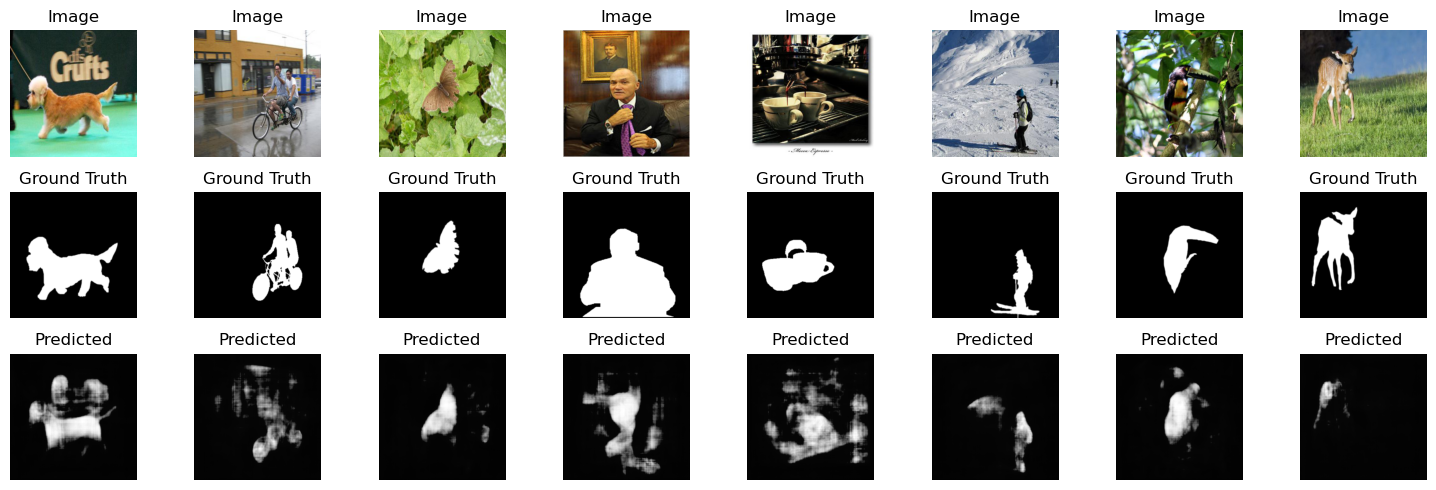

Test Loss: 0.0012269880516155003


In [3]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks, outputs, idx):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks.cpu().numpy()
    outputs = torch.sigmoid(outputs).cpu().numpy()

    fig, axs = plt.subplots(3, len(images), figsize=(15, 5))

    for i in range(len(images)):
        # Original Image
        axs[0, i].imshow(images[i])
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')
        
        # Ground Truth Mask
        axs[1, i].imshow(masks[i][0], cmap='gray')
        axs[1, i].set_title('Ground Truth')
        axs[1, i].axis('off')
        
        # Predicted Mask
        axs[2, i].imshow(outputs[i][0], cmap='gray')
        axs[2, i].set_title('Predicted')
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)
        
        if idx == 0:
            visualize_predictions(images, masks, outputs, idx)
            break


test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")